In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
""" Dataset directories """
train_data_dir = "Dataset/Preprocessed/Tomato/train_set"
test_data_dir = "Dataset/Preprocessed/Tomato/test_set"

In [14]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{train_data_dir}/healthy")[0]
img = plt.imread(f"{train_data_dir}/healthy/{first_image_file}")

img_height, img_width, _ = img.shape

img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 400x400 -> 400


In [15]:
""" Set batch size """
batch_size = 16

In [16]:
""" Data augmentation and preprocessing """
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)

Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


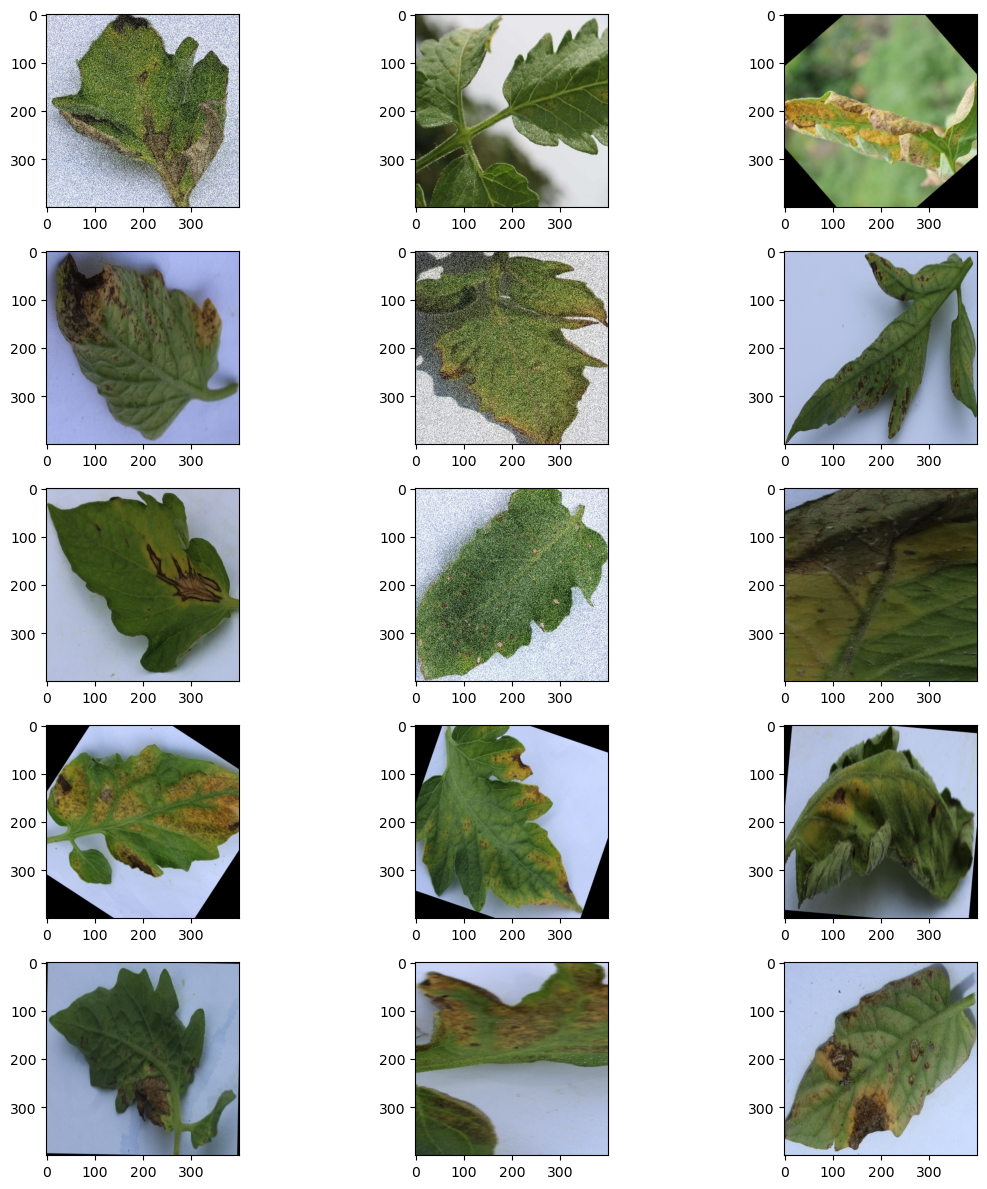

In [17]:
""" Display sample images """
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
""" Number of classes """
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [19]:
""" Set number of epochs """
epochs_number = 200

In [20]:
""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001)

#### Training ResNet-50 model


In [21]:
""" Load ResNet50V2 model """
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

""" Freeze the base model """
for layer in base_resNet_model.layers:
    layer.trainable = False
    
""" Add custom layers """
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# x = base_resNet_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, kernel_regularizer=L2(0.005))(x)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(512, kernel_regularizer=L2(0.005))(x)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(1024, kernel_regularizer=L2(0.005))(x)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(512, kernel_regularizer=L2(0.005))(x)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(256, kernel_regularizer=L2(0.005))(x)
# x = ReLU()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# predictions = Dense(num_classes, activation="softmax")(x)

""" Create model """
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

""" Compile model """
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/200
1357/1357 [==============================] - 100s 72ms/step - loss: 1.1090 - accuracy: 0.5653 - val_loss: 0.8004 - val_accuracy: 0.6752
Epoch 2/200
1357/1357 [==============================] - 97s 72ms/step - loss: 0.8925 - accuracy: 0.6449 - val_loss: 0.7373 - val_accuracy: 0.7108
Epoch 3/200
1357/1357 [==============================] - 95s 70ms/step - loss: 0.8094 - accuracy: 0.6748 - val_loss: 0.6221 - val_accuracy: 0.7638
Epoch 4/200
1357/1357 [==============================] - 95s 70ms/step - loss: 0.7401 - accuracy: 0.7044 - val_loss: 0.5897 - val_accuracy: 0.7752
Epoch 5/200
1357/1357 [==============================] - 95s 70ms/step - loss: 0.6788 - accuracy: 0.7328 - val_loss: 0.4916 - val_accuracy: 0.8154
Epoch 6/200
1357/1357 [==============================] - 95s 70ms/step - loss: 0.6281 - accuracy: 0.7541 - val_loss: 0.4845 - val_accuracy: 0.8211
Epoch 7/200
1357/1357 [==============================] - 96s 70ms/step - loss: 0.5715 - accuracy: 0.7771 - val_loss: 

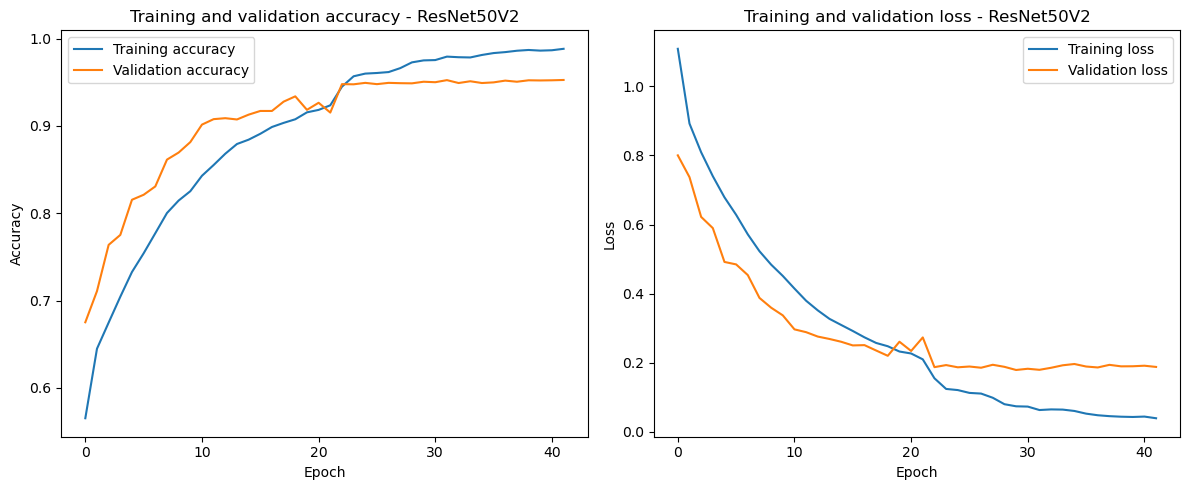

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [24]:
""" Save model """
resnet_model.save("resNet_model.h5")

""" Save history """
with open("resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
""" Evaluate model """
score = resnet_model.evaluate(test_generator)

print(f"Test loss: {score[0]:.3f}")
print(f"Test accuracy: {score[1]:.3f}")

341/341 [==============================] - 20s 58ms/step - loss: 0.1793 - accuracy: 0.9522
Test loss: 0.179
Test accuracy: 0.952
